# Day 3 — Churn EDA & Feature Engineering

**Goals:**
- Load small HR churn dataset (SQLite)
- Explore distributions and class balance
- Create ML-ready features (scale numeric, one-hot categorical)
- Save a processed table for modeling (used by Day 3 — Baselines & Metrics)

In [9]:
import sys, os, sqlite3
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Optional: seaborn for nicer plots (fallback to matplotlib if missing)
try:
    import seaborn as sns
except Exception:
    sns = None

rng = np.random.default_rng(0)
print("Python:", sys.version.split()[0], "| pandas:", pd.__version__, "| seaborn:", getattr(sns, "__version__", "not installed"))

Python: 3.13.7 | pandas: 2.3.2 | seaborn: 0.13.2


In [10]:
from pathlib import Path
import sqlite3, pandas as pd
import os

# Try common locations relative to wherever the notebook is running
candidates = [
    Path("data/hr.db"),
    Path("../data/hr.db"),
    Path("../../data/hr.db"),
]

db_path = next((p for p in candidates if p.exists()), None)
if db_path is None:
    # Optional: try to resolve repo root via git (works if repo is a git repo)
    try:
        import subprocess
        git_root = subprocess.run(
            ["git", "rev-parse", "--show-toplevel"],
            capture_output=True, text=True, check=False
        ).stdout.strip()
        if git_root:
            maybe = Path(git_root) / "data/hr.db"
            if maybe.exists():
                db_path = maybe
    except Exception:
        pass

if db_path is None:
    raise FileNotFoundError(
        "Couldn't find hr.db. Expected at one of: "
        + ", ".join(str(p) for p in candidates + ([Path(git_root)/'data/hr.db'] if 'git_root' in locals() and git_root else []))
        + "\nIf missing, recreate or copy it into this repo's data/ folder."
    )

with sqlite3.connect(db_path) as conn:
    df = pd.read_sql_query("SELECT * FROM employees", conn)

print(f"Loaded DB at: {db_path}  | df.shape = {df.shape}")
df.head()

Loaded DB at: ../data/hr.db  | df.shape = (8, 7)


,employee_id,age,dept,years_at_company,monthly_income,over_time,left_company
0,1,29,Sales,3.0,4200.0,1,0
1,2,41,Engineering,8.0,9800.0,0,0
2,3,35,Support,2.0,3500.0,1,1
3,4,50,Engineering,20.0,14200.0,0,0
4,5,26,Sales,1.0,3100.0,1,1


In [11]:
# Numeric summary
num_desc = df.select_dtypes(include="number").describe()
display(num_desc)

# Categorical summary
cat_desc = df.select_dtypes(include=["object", "category"]).describe()
display(cat_desc)

print("\nDtypes:\n", df.dtypes)

# Class balance (counts and proportions)
cls = df["left_company"].value_counts(dropna=False)
cls_norm = df["left_company"].value_counts(normalize=True, dropna=False)
display(pd.DataFrame({"count": cls, "prop": cls_norm.round(3)}))

,employee_id,age,years_at_company,monthly_income,over_time,left_company
count,8.00000,8.000000,8.000000,8.000000,8.000000,8.000000
mean,4.50000,37.000000,6.625000,7000.000000,0.500000,0.375000
std,2.44949,8.141604,6.093029,3917.725288,0.534522,0.517549
min,1.00000,26.000000,1.000000,3100.000000,0.000000,0.000000
25%,2.75000,31.250000,2.750000,4025.000000,0.000000,0.000000
50%,4.50000,36.500000,5.000000,5650.000000,0.500000,0.000000
75%,6.25000,42.000000,8.250000,9825.000000,1.000000,1.000000
max,8.00000,50.000000,20.000000,14200.000000,1.000000,1.000000


,dept
count,8
unique,4
top,Engineering
freq,3



Dtypes:
 employee_id           int64
age                   int64
dept                 object
years_at_company    float64
monthly_income      float64
over_time             int64
left_company          int64
dtype: object


,count,prop
left_company,,
0,5,0.625
1,3,0.375


**Notes**
- `over_time` is encoded as 0/1 already.
- `dept` is categorical text and will be one-hot encoded.
- We’ll standardize numeric features using **train split** statistics to avoid leakage.

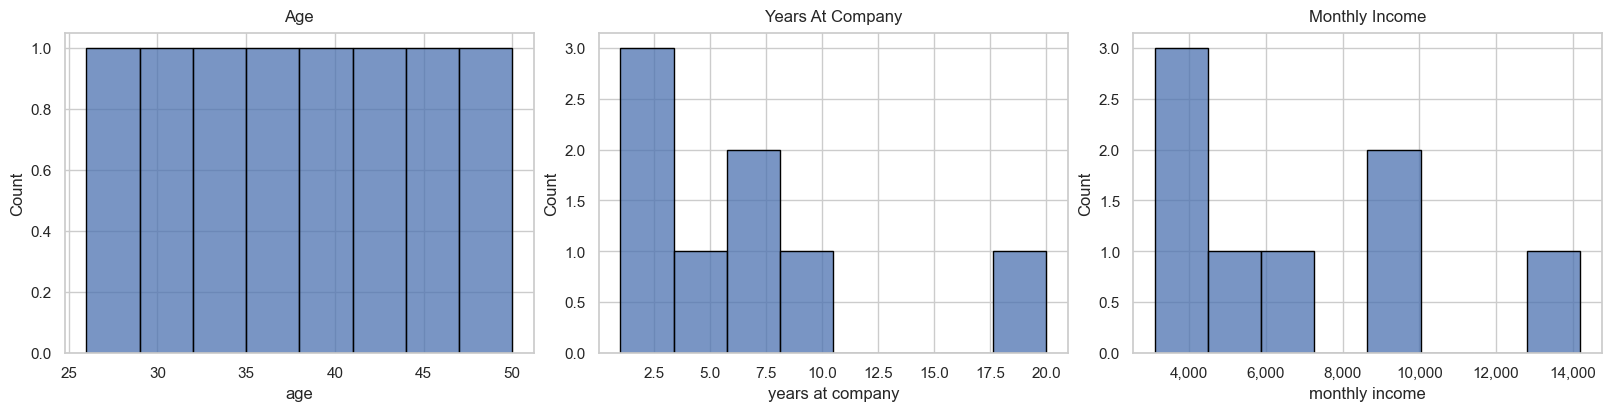

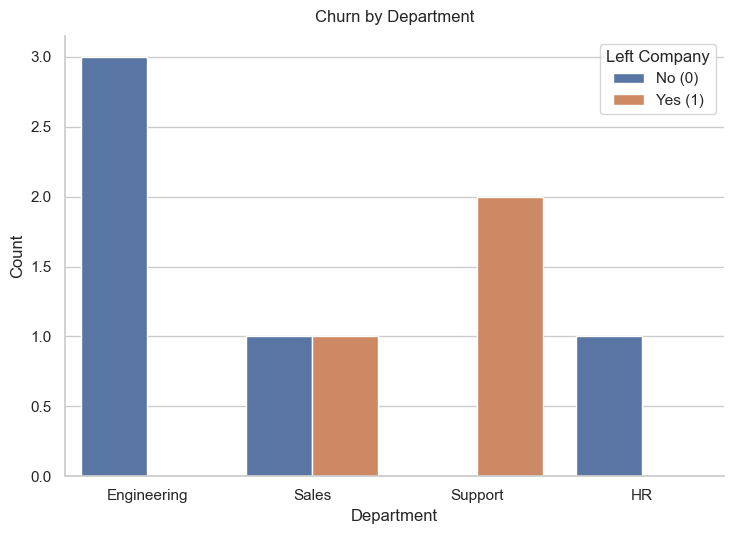

In [12]:
# Professionalized quick visuals (replace the old plotting cell with this)
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.ticker import FuncFormatter

sns.set_theme(style="whitegrid", context="notebook")

numeric_cols = ["age", "years_at_company", "monthly_income"]

# --- Histograms for numeric features ---------------------------------------
fig, axes = plt.subplots(1, 3, figsize=(16, 4), constrained_layout=True)
for ax, col in zip(axes, numeric_cols):
    # sensible bin count for tiny data
    bins = min(10, max(3, df[col].nunique()))
    sns.histplot(data=df, x=col, bins=bins, edgecolor="black", ax=ax)
    ax.set_title(col.replace("_", " ").title(), pad=8)
    ax.set_xlabel(col.replace("_", " "))
    ax.set_ylabel("Count")
# format income axis a bit nicer (optional)
axes[2].xaxis.set_major_formatter(FuncFormatter(lambda x, pos: f"{int(x):,}"))

plt.show()

# --- Categorical by target: dept vs churn -----------------------------------
plt.figure(figsize=(7.5, 5.5))
dept_order = df["dept"].value_counts().index
ax = sns.countplot(data=df, x="dept", hue="left_company", order=dept_order)
ax.set_title("Churn by Department", pad=10)
ax.set_xlabel("Department")
ax.set_ylabel("Count")
ax.legend(title="Left Company", labels=["No (0)", "Yes (1)"], frameon=True, loc="upper right")
sns.despine()
plt.tight_layout()
plt.show()

**Split & Features**
- Split data 80/20 with a fixed seed for reproducibility.
- Standardize numeric: `z = (x - μ_train) / σ_train`
- One-hot encode `dept` using **train** categories (drop first to avoid collinearity)
- Keep `over_time` as 0/1 (rename to `x_over_time`)
- Save: `data/day3_features.csv` with columns:
  - `x_*` feature columns
  - `y` (label)
  - `split` in {train, test}

In [13]:
# Identify columns
numeric_cols = ["age", "years_at_company", "monthly_income"]
cat_col = "dept"
label_col = "left_company"

# Train/test split
idx = np.arange(len(df))
rng = np.random.default_rng(3)
idx = rng.permutation(idx)
train_n = int(0.8 * len(idx))
tr, te = idx[:train_n], idx[train_n:]

split = np.array(["train"] * len(df), dtype=object)
split[te] = "test"

# Ensure dtypes
df = df.copy()
df["over_time"] = df["over_time"].astype(int)
df[label_col] = df[label_col].astype(int)
df[cat_col] = df[cat_col].astype("category")

# --- Standardize numeric using train stats ---
mu = df.loc[tr, numeric_cols].mean()
sigma = df.loc[tr, numeric_cols].std().replace(0, 1.0)

Z = (df[numeric_cols] - mu) / sigma
Z.columns = [f"x_{c}_z" for c in Z.columns]

# --- One-hot for dept using TRAIN categories, drop_first ---
train_cats = list(df.loc[tr, cat_col].cat.categories)  # categories seen overall (since it's categorical)
# Recreate dummies on train to decide baseline (drop_first)
train_dummies = pd.get_dummies(df.loc[tr, cat_col], prefix="x_dept", drop_first=True)
dummy_cols = sorted(train_dummies.columns)

# Build full dummies frame with same columns for all rows (fill missing with 0)
D = pd.get_dummies(df[cat_col], prefix="x_dept", drop_first=True)
for c in dummy_cols:
    if c not in D.columns:
        D[c] = 0
D = D[dummy_cols].astype(int)

# --- Binary feature for over_time ---
x_over = df["over_time"].astype(int).rename("x_over_time")

# --- Assemble features ---
X = pd.concat([Z, D, x_over], axis=1)
y = df[label_col].rename("y")
out = pd.concat([X, y, pd.Series(split, name="split")], axis=1)

# Save processed table (used by the modeling notebook)
os.makedirs("data", exist_ok=True)
out.to_csv("data/day3_features.csv", index=False)

print("Feature columns:", list(X.columns))
print("Train size:", (out["split"]=="train").sum(), " Test size:", (out["split"]=="test").sum())
out.head()

Feature columns: ['x_age_z', 'x_years_at_company_z', 'x_monthly_income_z', 'x_dept_HR', 'x_dept_Sales', 'x_dept_Support', 'x_over_time']
Train size: 6  Test size: 2


,x_age_z,x_years_at_company_z,x_monthly_income_z,x_dept_HR,x_dept_Sales,x_dept_Support,x_over_time,y,split
0,-1.064017,-0.620174,-0.692489,0,1,0,1,0,test
1,0.717593,0.930261,1.183933,0,0,0,0,0,train
2,-0.173212,-0.930261,-0.927042,0,0,1,1,1,train
3,2.053801,4.651303,2.658264,0,0,0,0,0,test
4,-1.509420,-1.240347,-1.061072,0,1,0,1,1,train


✅ Features saved to `data/day3_features.csv`.

Next, open **Day 3 — Baselines & Metrics** to:
- Train a baseline (majority class)
- Train logistic regression
- Evaluate confusion matrix, ROC, PR
- Pick a probability threshold